In [2]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 2.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 2.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 2.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 3.2 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import scipy.io
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

def dataloader(path):
    data = scipy.io.loadmat(path)
    AF = data['AF']
    modified_rows1 = AF[:-2]
    last_rows1 = AF[-2:]
    CF = data['CF']
    concatenated_array = np.concatenate((modified_rows1, CF,last_rows1), axis=0)
    new=concatenated_array
    u, count = np.unique(new[-1], return_counts=True)
    a = u[np.logical_or(count < 2, count > 2)]
    c = new[:, np.isin(new[-1], a, invert=True)]
    x = c[0:-2]; y = c[-2]; w = c[-1];
    return x.T, y.T, w.T, data['CF_info']

def calculate_accuracy(arr1, arr2):
    count = sum(1 for itr1, itr2 in zip(arr1, arr2) if itr1 == itr2)
    return count / len(arr1)

def count_zeros(array):
    count = 0
    for element in array:
        if element == 0:
            count += 1
    return count

def normalization(feats):
    df = pd.DataFrame(feats)
    scaler = StandardScaler()
    x_new = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return x_new
    
def calculate_confidence(soft_assignments):
    # Calculate confidence as the maximum soft assignment value
    confidence = np.max(soft_assignments, axis=1)
    return confidence
        
fatyp = 'TypicalFA_comb1'
drivepath = 'finalData/'+ fatyp +'/';
filee = drivepath+'GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress.mat'
original_dim = 38
train_path = filee; test_path = filee.replace('train','test')
xtrain, ytrain, wtrain1, info_train1 = dataloader(train_path);
xtest, ytest, wtest1, info_test1 = dataloader(test_path);
xtest= normalization(xtest)
xtrain= normalization(xtrain)

woPP=[]; wPP=[]
input_shape1 = (19,1)
input_shape2 = (38,1)
temperature = 0.03
learning_rate=0.001

2023-07-05 06:56:28.359518: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


124/124 [==============================] - 0s 1ms/step
Epoch 1/10 - Adjusted Rand Index (ARI): 0.02706951333667825 - Accuracy: 0.5824924318869829 - Confidence: 0.9261270493216158
Epoch 2/10 - Adjusted Rand Index (ARI): 0.026244727006087463 - Accuracy: 0.5812310797174571 - Confidence: 0.9286480178225173
Epoch 3/10 - Adjusted Rand Index (ARI): 0.025755909165195663 - Accuracy: 0.5804742684157417 - Confidence: 0.9292046800864481
Epoch 4/10 - Adjusted Rand Index (ARI): 0.025919067538060274 - Accuracy: 0.5807265388496469 - Confidence: 0.9295160904596225
Epoch 5/10 - Adjusted Rand Index (ARI): 0.02608242273654562 - Accuracy: 0.580978809283552 - Confidence: 0.9297047501501164
Epoch 6/10 - Adjusted Rand Index (ARI): 0.02608242273654562 - Accuracy: 0.580978809283552 - Confidence: 0.9297675769526745
Epoch 7/10 - Adjusted Rand Index (ARI): 0.02608242273654562 - Accuracy: 0.580978809283552 - Confidence: 0.9297675769526745
Epoch 8/10 - Adjusted Rand Index (ARI): 0.02608242273654562 - Accuracy: 0.580

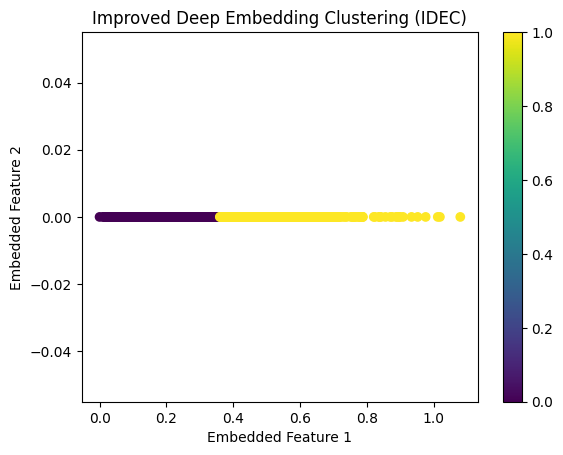

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

# Define the Improved Deep Embedding Clustering (IDEC) model
input_dim = xtrain_scaled.shape[1]
latent_dim = 2
n_clusters = 2

input_layer = Input(shape=(input_dim,))
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dense(64, activation='relu')(encoder)
encoder = Dense(32, activation='relu')(encoder)
encoder = Dense(16, activation='relu')(encoder)
encoder = Dense(8, activation='relu')(encoder)
encoder = Dense(4, activation='relu')(encoder)
encoder = Dense(latent_dim, activation='relu')(encoder)

decoder = Dense(4, activation='relu')(encoder)
decoder = Dense(8, activation='relu')(decoder)
decoder = Dense(16, activation='relu')(decoder)
decoder = Dense(32, activation='relu')(decoder)
decoder = Dense(64, activation='relu')(decoder)
decoder = Dense(128, activation='relu')(decoder)
decoder = Dense(input_dim, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(), loss='mse')

# Train the autoencoder
autoencoder.fit(xtrain_scaled, xtrain_scaled, epochs=50, batch_size=64, verbose=0)

# Extract the learned embeddings
encoder_model = Model(inputs=input_layer, outputs=encoder)
embeddings = encoder_model.predict(xtrain_scaled)

# Initialize cluster centers using Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=n_clusters)
gmm.fit(embeddings)
cluster_centers = gmm.means_

# Initialize soft assignments
soft_assignments = gmm.predict_proba(embeddings)

# IDEC training loop
epochs = 10
batch_size = 64

for epoch in range(epochs):
    # Update cluster centers
    cluster_centers_old = cluster_centers.copy()

    for i in range(n_clusters):
        cluster_centers[i] = np.mean(embeddings[soft_assignments[:, i] > 0.5], axis=0)

    # Update soft assignments
    soft_assignments = gmm.predict_proba(embeddings)

    # Calculate Adjusted Rand Index (ARI)
    labels = np.argmax(soft_assignments, axis=1)
    ari = adjusted_rand_score(ytrain, labels)
    accuracy = calculate_accuracy(ytrain, labels)

    # Calculate confidence
    confidence = calculate_confidence(soft_assignments)
    # Set the confidence threshold
#     confidence_threshold = 0.8

#     # Filter the data points based on confidence threshold
#     high_confidence_indices = np.where(confidence >= confidence_threshold)[0]
#     high_confidence_labels = labels[high_confidence_indices]

# # Print the high confidence labels
#     print("High Confidence Labels:")
#     print(high_confidence_labels)

    # Print ARI, Accuracy, and Confidence for each epoch
    print(f"Epoch {epoch+1}/{epochs} - Adjusted Rand Index (ARI): {ari} - Accuracy: {accuracy} - Confidence: {np.mean(confidence)}")

# Plot the clusters
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis')
plt.title("Improved Deep Embedding Clustering (IDEC)")
plt.xlabel("Embedded Feature 1")
plt.ylabel("Embedded Feature 2")
plt.colorbar()
plt.show()


In [3]:
print(count_zeros(labels))


3964


124/124 [==============================] - 0s 1ms/step
Epoch 1/10 - Adjusted Rand Index (ARI): 6.573711667572573e-05 - Accuracy: 0.5042885973763875 - Confidence: 0.9999999999942702
Epoch 2/10 - Adjusted Rand Index (ARI): 6.573711667572573e-05 - Accuracy: 0.5042885973763875 - Confidence: 0.9999999999942702
Epoch 3/10 - Adjusted Rand Index (ARI): 6.573711667572573e-05 - Accuracy: 0.5042885973763875 - Confidence: 0.9999999999942702
Epoch 4/10 - Adjusted Rand Index (ARI): 6.573711667572573e-05 - Accuracy: 0.5042885973763875 - Confidence: 0.9999999999942702
Epoch 5/10 - Adjusted Rand Index (ARI): 6.573711667572573e-05 - Accuracy: 0.5042885973763875 - Confidence: 0.9999999999942702
Epoch 6/10 - Adjusted Rand Index (ARI): 6.573711667572573e-05 - Accuracy: 0.5042885973763875 - Confidence: 0.9999999999942702
Epoch 7/10 - Adjusted Rand Index (ARI): 6.573711667572573e-05 - Accuracy: 0.5042885973763875 - Confidence: 0.9999999999942702
Epoch 8/10 - Adjusted Rand Index (ARI): 6.573711667572573e-05 -

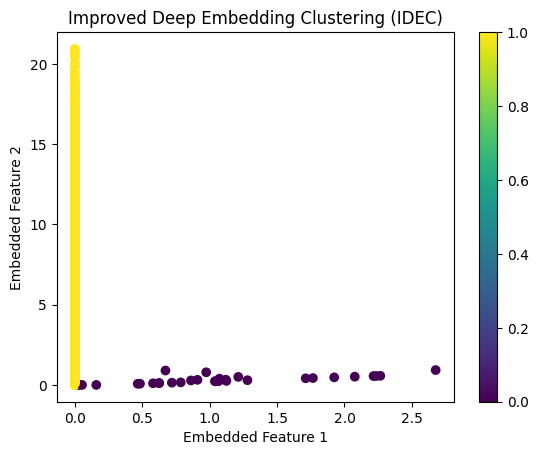

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

# Define the Improved Deep Embedding Clustering (IDEC) model
input_dim = xtrain_scaled.shape[1]
latent_dim = 4
n_clusters = 2

input_layer = Input(shape=(input_dim,))
encoder = Dense(128, activation='relu')(input_layer)
encoder = Dense(64, activation='relu')(encoder)
encoder = Dense(32, activation='relu')(encoder)
encoder = Dense(16, activation='relu')(encoder)
encoder = Dense(8, activation='relu')(encoder)
encoder = Dense(4, activation='relu')(encoder)
encoder = Dense(latent_dim, activation='relu')(encoder)

decoder = Dense(4, activation='relu')(encoder)
decoder = Dense(8, activation='relu')(decoder)
decoder = Dense(16, activation='relu')(decoder)
decoder = Dense(32, activation='relu')(decoder)
decoder = Dense(64, activation='relu')(decoder)
decoder = Dense(128, activation='relu')(decoder)
decoder = Dense(input_dim, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer=Adam(), loss='mse')

# Train the autoencoder
autoencoder.fit(xtrain_scaled, xtrain_scaled, epochs=50, batch_size=64, verbose=0)

# Extract the learned embeddings
encoder_model = Model(inputs=input_layer, outputs=encoder)
embeddings = encoder_model.predict(xtrain_scaled)

# Initialize cluster centers using Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=n_clusters)
gmm.fit(embeddings)
cluster_centers = gmm.means_

# Initialize soft assignments
soft_assignments = gmm.predict_proba(embeddings)

# IDEC training loop
epochs = 10
batch_size = 64

for epoch in range(epochs):
    # Update cluster centers
    cluster_centers_old = cluster_centers.copy()

    for i in range(n_clusters):
        cluster_centers[i] = np.mean(embeddings[soft_assignments[:, i] > 0.5], axis=0)

    # Update soft assignments
    soft_assignments = gmm.predict_proba(embeddings)

    # Calculate Adjusted Rand Index (ARI)
    labels = np.argmax(soft_assignments, axis=1)
    ari = adjusted_rand_score(ytrain, labels)
    accuracy = calculate_accuracy(ytrain, labels)

    # Calculate confidence
    confidence = calculate_confidence(soft_assignments)
    # Set the confidence threshold
#     confidence_threshold = 0.8

#     # Filter the data points based on confidence threshold
#     high_confidence_indices = np.where(confidence >= confidence_threshold)[0]
#     high_confidence_labels = labels[high_confidence_indices]

# # Print the high confidence labels
#     print("High Confidence Labels:")
#     print(high_confidence_labels)

    # Print ARI, Accuracy, and Confidence for each epoch
    print(f"Epoch {epoch+1}/{epochs} - Adjusted Rand Index (ARI): {ari} - Accuracy: {accuracy} - Confidence: {np.mean(confidence)}")

# Plot the clusters
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis')
plt.title("Improved Deep Embedding Clustering (IDEC)")
plt.xlabel("Embedded Feature 1")
plt.ylabel("Embedded Feature 2")
plt.colorbar()
plt.show()


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, pairwise_distances
from scipy.spatial.distance import cdist


class IDEC_LS:
    def __init__(self, input_dim, latent_dim, n_clusters):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=self.n_clusters)
        self.encoder_model = None
        self.embedding = None

    def build_model(self):
        input_layer = Input(shape=(self.input_dim,))
        encoder = Dense(128, activation='relu')(input_layer)
        encoder = Dense(64, activation='relu')(encoder)
        encoder = Dense(32, activation='relu')(encoder)
        encoder = Dense(16, activation='relu')(encoder)
        encoder = Dense(8, activation='relu')(encoder)
        encoder = Dense(4, activation='relu')(encoder)
        encoder = Dense(self.latent_dim, activation='relu')(encoder)

        decoder = Dense(4, activation='relu')(encoder)
        decoder = Dense(8, activation='relu')(decoder)
        decoder = Dense(16, activation='relu')(decoder)
        decoder = Dense(32, activation='relu')(decoder)
        decoder = Dense(64, activation='relu')(decoder)
        decoder = Dense(128, activation='relu')(decoder)
        decoder = Dense(self.input_dim, activation='linear')(decoder)

        autoencoder = Model(inputs=input_layer, outputs=decoder)
        autoencoder.compile(optimizer=Adam(), loss='mse')

        self.encoder_model = Model(inputs=input_layer, outputs=encoder)
        return autoencoder

    def initialize_cluster_centers(self, x):
        self.kmeans.fit(self.encoder_model.predict(x))

    def update_cluster_centers(self, x):
        self.kmeans.fit(self.embedding)

    def target_distribution(self, q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def fit(self, x, y, epochs=50, batch_size=64):
        autoencoder = self.build_model()
        autoencoder.fit(x, x, epochs=epochs, batch_size=batch_size, verbose=0)
        self.embedding = self.encoder_model.predict(x)
        self.initialize_cluster_centers(x)

        for epoch in range(epochs):
            q = self.kmeans.transform(self.embedding) ** 2
            p = self.target_distribution(q)
            autoencoder.fit(x, p, epochs=1, batch_size=batch_size, verbose=0)
            self.embedding = self.encoder_model.predict(x)
            self.update_cluster_centers(x)

        labels = self.kmeans.labels_
        ari = adjusted_rand_score(y, labels)
        return labels, ari


input_dim = xtrain.shape[1]
latent_dim = 2
n_clusters = 2

idec_ls = IDEC_LS(input_dim, latent_dim, n_clusters)
labels, ari = idec_ls.fit(xtrain, ytrain, epochs=50, batch_size=64)

plt.scatter(idec_ls.embedding[:, 0], idec_ls.embedding[:, 1], c=labels, cmap='viridis')
plt.title("Improved Deep Embedded Clustering with Local Structure Preservation (IDEC-LS)")
plt.xlabel("Embedded Feature 1")
plt.ylabel("Embedded Feature 2")
plt.colorbar()
plt.show()

print("Adjusted Rand Index (ARI):", ari)


SyntaxError: unexpected EOF while parsing (3099016826.py, line 89)